In [ ]:
! pip install datasets

In [ ]:
! pip install sacrebleu

In [ ]:
! pip install accelerate -U

In [5]:
import requests
import pandas as pd
import time

from datasets import load_dataset

from huggingface_hub import notebook_login
from huggingface_hub import HfFolder
from huggingface_hub import InferenceApi

import sacrebleu

import matplotlib.pyplot as plt

import torch

import transformers
from transformers import AutoTokenizer, MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import Trainer, TrainingArguments

from torch.utils.data import DataLoader, Dataset

In [6]:
french_dataset = load_dataset("demelin/wino_x", 'lm_en_fr')

Generating test split:   0%|          | 0/2793 [00:00<?, ? examples/s]

In [7]:
full_data = french_dataset['test']

english_translations = [sample['context_en'] for sample in full_data]
french_translations = [sample['context_fr'] for sample in full_data]

# Create DataFrame
fr_df = pd.DataFrame({'English': english_translations, 'French': french_translations})

fr_df = fr_df[fr_df.index % 2 == 0]
fr_df = fr_df[:1]
display(fr_df)

,English,French
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...


In [8]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

In [9]:
def infer(prompt):
  inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)

  # Translate the input sentence to English
  translated_ids = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["fr_XX"])

  # Decode the translated sentence
  return tokenizer.decode(translated_ids[0], skip_special_tokens=True)

In [10]:
# Function to apply infer() to each row and return the output
def apply_infer(row):
    output = infer(row['English'])
    return output

fr_df['LLM_Translation'] = fr_df.apply(apply_infer, axis=1)

# Print the DataFrame with the new 'OutputColumn'
display(fr_df)

,English,French,LLM_Translation
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...,La femme a cherché un vase différent pour le b...


In [11]:
def compute_bleu(row):
    reference = [row['French']]
    candidate = [row['LLM_Translation']]
    return sacrebleu.corpus_bleu(candidate, [reference]).score

fr_df['bleu_score'] = fr_df.apply(compute_bleu, axis=1)
display(fr_df)

,English,French,LLM_Translation,bleu_score
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...,La femme a cherché un vase différent pour le b...,74.478198


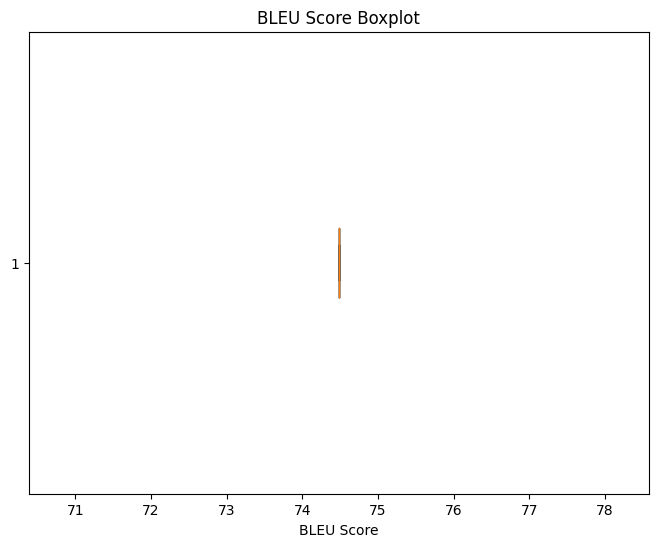

In [12]:
plt.figure(figsize=(8, 6))
plt.boxplot(fr_df['bleu_score'], vert=False)
plt.title('BLEU Score Boxplot')
plt.xlabel('BLEU Score')
plt.show()

In [ ]:
# Calculate length of each sentence
english_lengths = [len(row['English']) for index, row in fr_df.iterrows()]
french_lengths = [len(row['French']) for index, row in fr_df.iterrows()]


plt.figure(figsize=(8, 6))
plt.scatter(english_lengths, fr_df['bleu_score'], label='English', color='blue', marker='o')
plt.scatter(french_lengths, fr_df['bleu_score'], label='French', color='green', marker='s')


plt.xlabel('Sentence Length')
plt.ylabel('Similarity Score')
plt.title('Relationship between Sentence Length and Similarity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### LLM Fine Tuning

In [13]:
indices_to_keep = list(range(0, len(full_data), 2))

full_data = full_data.select(indices_to_keep)

In [14]:
train_data = full_data.select(range(500))

test_data = full_data.select(range(550, 600))

In [15]:
# Define function to tokenize examples
def tokenize_examples(example):
    inputs = tokenizer(example["context_fr"], example["context_en"], return_tensors="pt", padding=True, truncation=True, max_length=512)

    target_inputs = tokenizer(example["context_en"], return_tensors="pt", padding=True, truncation=True, max_length=512)

    inputs["labels"] = target_inputs["input_ids"]

    return inputs

train_dataset = train_data.map(tokenize_examples, batched=True)
eval_dataset = test_data.map(tokenize_examples, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [17]:
train_dataset.remove_columns(['qID', 'sentence', 'answer', 'option1_en', 'option2_en', 'option1_fr', 'option2_fr', 'context_referent_of_option1_fr', 'context_referent_of_option2_fr', 'input_ids', 'attention_mask', 'labels'])
eval_dataset.remove_columns(['qID', 'sentence', 'answer', 'option1_en', 'option2_en', 'option1_fr', 'option2_fr', 'context_referent_of_option1_fr', 'context_referent_of_option2_fr', 'input_ids', 'attention_mask', 'labels'])

Dataset({
    features: ['context_en', 'context_fr'],
    num_rows: 50
})

In [18]:
english_sentences = [row['English'] for index, row in fr_df.iterrows()]
french_sentences = [row['French'] for index, row in fr_df.iterrows()]

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=375, training_loss=1.4480519205729168, metrics={'train_runtime': 194.8704, 'train_samples_per_second': 7.697, 'train_steps_per_second': 1.924, 'total_flos': 253960519680000.0, 'train_loss': 1.4480519205729168, 'epoch': 3.0})

In [ ]:
from transformers import pipeline
translation_pipeline = pipeline("translation", model=model, tokenizer=tokenizer, src_lang="en", tgt_lang="fr")

predictions = []
for example in eval_dataset:
    en_text = example["context_en"]
    translated_text = translation_pipeline(en_text, max_length=128, num_return_sequences=1, num_beams=4)
    predictions.append(translated_text[0]['translation_text'])

In [38]:
references = test_data['context_en']
bleu = sacrebleu.corpus_bleu(predictions, references)

print("BLEU Score:", bleu.score)

BLEU Score: 0.09068388741500776
